# Causal Inference from Games and Student Data

## Abstract

This notebook presents a comprehensive, hands-on exploration of causal inference using a dataset on gaming behavior and academic performance among students. The analysis begins with data preparation steps, including loading the dataset, inspecting variable distributions, handling missing values, and performing feature cleaning and encoding to ensure compatibility with statistical modeling. Following preprocessing, exploratory data analysis (EDA) is used to examine how gaming habits—such as hours played, frequency, and years of experience—differ across demographic groups and relate to academic outcomes. The notebook then introduces the concept of causality and highlights the limitations of simple correlation, emphasizing how causal analysis offers deeper insights into what causes what, rather than merely identifying predictive relationships.

The core causal question guiding this analysis is:  
"Does the amount of time a student spends playing video games causally affect their academic grade?"

Using domain knowledge and visual intuition, a Directed Acyclic Graph (DAG) is constructed to represent assumptions and identify key confounders such as parental education, family income, school environment, and sex. These confounders are adjusted for in a linear regression model to isolate the causal effect of gaming hours on grades. The analysis also includes visualizations such as the regression line, correlation heatmap, and residual plots to assess model validity. Results indicate a statistically significant negative effect of gaming hours on academic performance, even after adjusting for confounding variables—highlighting the real-world implications of screen time on educational outcomes.

<div align="center">
<img src="https://raw.githubusercontent.com/gowrimg28/Dataset_GamesAndStudents/refs/heads/main/kidsplaying.jpg" width="1000"/>
</div>

## What is Causal Inference?

Causal inference is the process of determining whether one variable causes a change in another, rather than just being correlated. While machine learning models are great at predicting outcomes, they often struggle to explain why those outcomes occur.

Causal inference attempts to answer "what would happen if we intervened?" using tools such as:
- Counterfactuals: What would a student’s grade have been if they didn’t play games?
- Confounders: Variables that affect both the treatment (gaming) and outcome (grades).
- Causal Diagrams (DAGs): Visual tools to represent causal assumptions.
- Do-Calculus & Estimation: Mathematical techniques to estimate causal effects from observational data.

## Why Prediction Isn’t Enough:

Predictive models estimate outcomes based on patterns in data, but they do not reveal why those outcomes occur. For example, a model might show that students who play more video games tend to score lower grades. However, this association does not prove that gaming causes lower performance—other factors like parental involvement or school quality could be influencing both. Relying on prediction alone can lead to incorrect decisions if the relationships are not causal. Causal inference addresses this by aiming to isolate the true effect of one variable on another, ensuring that observed changes are not due to hidden influences.

## Confounding and Bias:

A confounder is a variable that affects both the cause and the effect. If not accounted for, it can bias our results. For instance, parental education may influence both how much a student plays games and their academic performance. Ignoring this can distort the estimated effect of gaming. To reduce bias, we identify confounders using causal diagrams (like DAGs) and adjust for them in statistical models. This helps produce more accurate and reliable estimates of causal effects.

## Dataset Overview

This notebook uses the Games and Students dataset, sourced from Kaggle. It contains data on student gaming habits, family background, and academic performance.

### Key Details
- Total entries: 770 students
- Target variable: Grade (academic performance as a numeric value)
- Primary variable of interest: Playing Hours (number of hours spent playing video games)
- Data types: A mix of categorical and numerical variables
- Missing values: Minimal, with one invalid Grade value removed during preprocessing

### Features in the Dataset
- Demographic attributes: Sex, School Code
- Gaming-related features: Playing Years, Playing Often, Playing Hours, Playing Games
- Family background: Parent Revenue, Father Education, Mother Education
- Academic outcome: Grade (percentage column was dropped due to formatting issues)

This dataset provides an appropriate structure for causal analysis, as it includes both behavioral and background variables. The presence of potential confounders, such as parental education and income, allows for a more accurate estimation of the effect of gaming on academic performance.

In [27]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import statsmodels.api as sm
# Set visual style for plots
sns.set(style="whitegrid")

In [2]:
# Load dataset from GitHub raw link
url = "https://raw.githubusercontent.com/gowrimg28/Dataset_GamesAndStudents/refs/heads/main/gameandgrade%20new.csv"

df = pd.read_csv(url)

# Show the first few rows
df.head()

,Sex,School Code,Playing Years,Playing Often,Playing Hours,Playing Games,Parent Revenue,Father Education,Mother Education,Grade,percentage
0,0,1,1,2,1,1,4,4,5,77.50,"7750,00%"
1,1,1,1,3,1,1,1,3,3,83.00,"8300,00%"
2,0,1,0,0,0,0,1,3,3,80.00,"8000,00%"
3,0,1,3,5,1,1,2,2,3,45.00,"4500,00%"
4,1,1,1,1,2,1,1,3,4,85.00,"8500,00%"


In [3]:
# Check the structure and data types
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sex               770 non-null    int64 
 1   School Code       770 non-null    int64 
 2   Playing Years     770 non-null    int64 
 3   Playing Often     770 non-null    int64 
 4   Playing Hours     770 non-null    int64 
 5   Playing Games     770 non-null    int64 
 6   Parent Revenue    770 non-null    int64 
 7   Father Education  770 non-null    int64 
 8   Mother Education  770 non-null    int64 
 9   Grade             770 non-null    object
 10  percentage        770 non-null    object
dtypes: int64(9), object(2)
memory usage: 66.3+ KB


(770, 11)

- df.info() provides a summary of the dataset, including:
  - The number of rows and columns (770 entries, 11 columns)
  - Column names, data types, and non-null counts
  - Memory usage

- df.shape returns the shape of the DataFrame, confirming it has 770 rows and 11 columns.

From the output, we observe:
- Most columns are of type int64, representing numerical values.
- Two columns — Grade and percentage — are stored as object types, likely because they contain non-numeric values or are formatted as strings.

In [4]:
# Check unique values in the 'Grade' column (should be numeric, but is object)
print("Unique values in 'Grade':")
print(df['Grade'].unique())

# Check formatting of 'percentage' column
print("\nSample values from 'percentage' column:")
print(df['percentage'].head())

Unique values in 'Grade':
['77.50' '83.00' '80.00' '45.00' '85.00' '55.00' '60.00' '88.00' '90.00'
 '74.00' '95.00' '50.00' '98.00' '87.00' '70.00' '65.00' '76.50' '61.00'
 '99.00' '77.00' '100' '75.00' '69.00' '67.00' '79.00' '36.50' '92.00'
 '93.00' '90.70' '78.00' '68.00' '64.00' '42.35' '72.50' '40.00' '63.00'
 '86.00' '62.00' '89.00' '48.00' '57.75' '94.00' '66.00' '71.00' '91.00'
 '57.00' '76.00' '73.00' '97.66' '82.50' '98.50' '78.50' '94.50' '95.24'
 '65.50' '85.50' '93.50' '90.80' '86.70' '59.00' '92.60' '53.00' '72.00'
 '82.00' '42.50' '92.50' '80.50' '83.50' '50.60' '97.50' '89.50' '55.50'
 '96.50' '52.00' '56.00' '67.20' '97.00' '92..00' '43.00' '59.69' '87.50'
 '90.50' '90' '67.50' '33.00' '85.30' '70.50' '49.53' '72.10' '80.33'
 '56.50' '96.00' '75.60' '79.80' '84.00' '95.33' '46.50' '95.50' '75.50'
 '60.50' '82.20' '81.00' '55.30' '64.75' '45.50']

Sample values from 'percentage' column:
0    7750,00%
1    8300,00%
2    8000,00%
3    4500,00%
4    8500,00%
Name: percenta

In [5]:
# Check for missing values in each column
print("Missing values in each column:\n")
print(df.isnull().sum())

Missing values in each column:

Sex                 0
School Code         0
Playing Years       0
Playing Often       0
Playing Hours       0
Playing Games       0
Parent Revenue      0
Father Education    0
Mother Education    0
Grade               0
percentage          0
dtype: int64


Based on above output we can say that their are no missing values in our dataset.

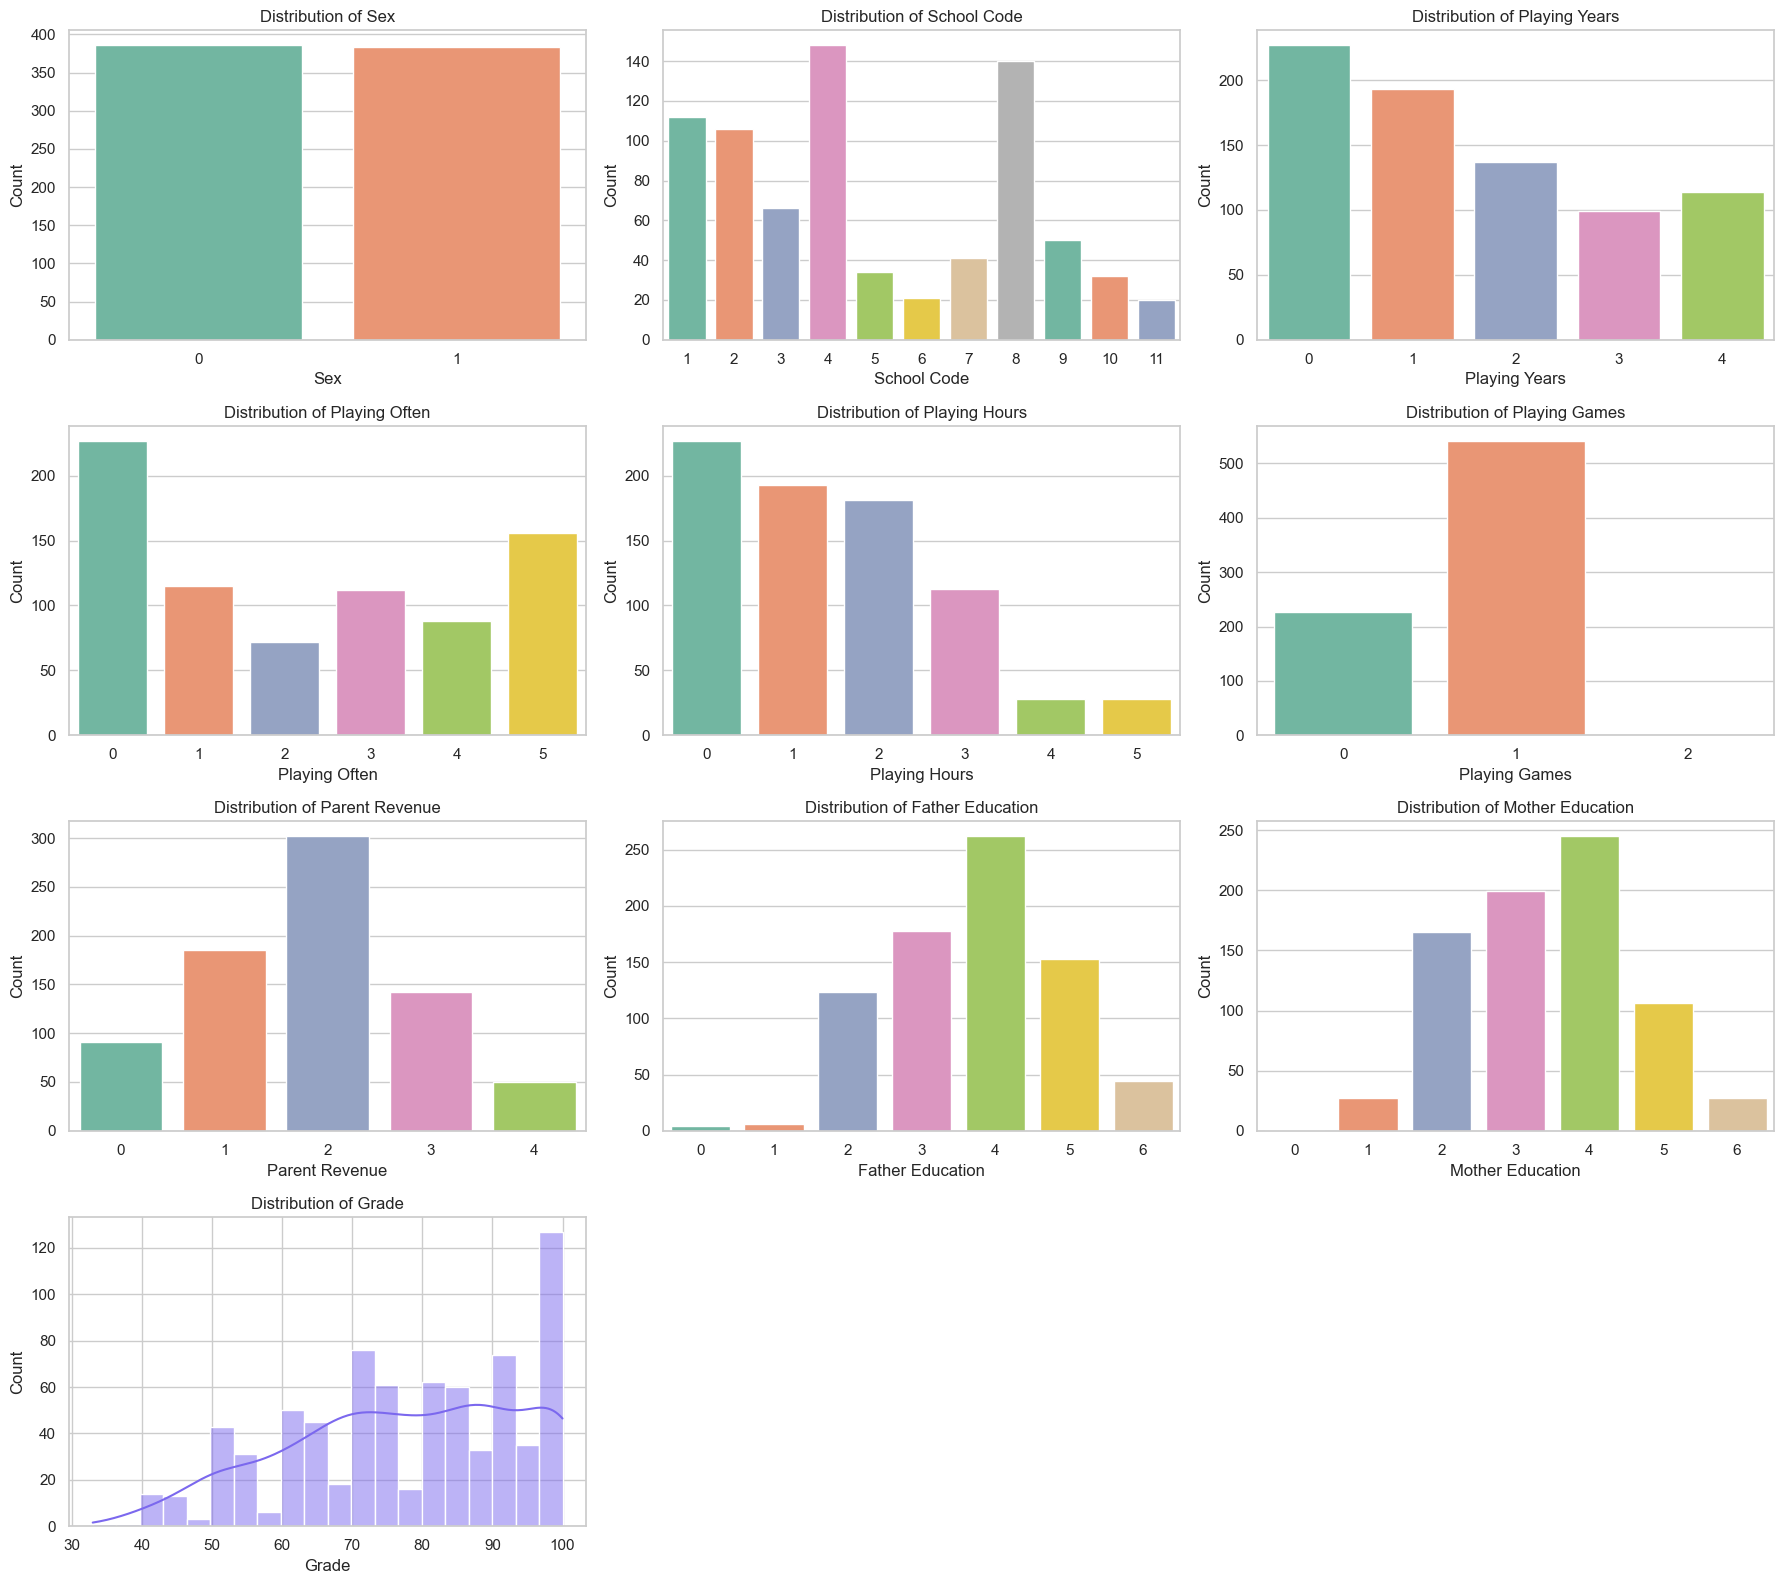

In [6]:
# Set figure style
sns.set(style="whitegrid")
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

# List of columns to visualize
columns = ['Sex', 'School Code', 'Playing Years', 'Playing Often', 'Playing Hours',
           'Playing Games', 'Parent Revenue', 'Father Education', 'Mother Education']

# Use a brighter but clean color palette
palette_choice = "Set2"

# Plot categorical/numeric as count plots
for i, col in enumerate(columns):
    sns.countplot(x=col, data=df, ax=axes[i], palette=palette_choice)
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Plot Grade (converted to float)
df['Grade'] = pd.to_numeric(df['Grade'], errors='coerce')
sns.histplot(df['Grade'], kde=True, bins=20, ax=axes[9], color='mediumslateblue')
axes[9].set_title('Distribution of Grade')
axes[9].set_xlabel('Grade')

# Remove unused subplots
for j in range(10, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


These distributions help us understand how balanced or skewed the dataset is, and which variables might be relevant for causal exploration.

##### Sex
- Encoded as binary (0 and 1), likely representing Female and Male.
- The distribution is nearly balanced, which is ideal for comparing academic performance across genders.

##### School Code
- Categorical feature ranging from 1 to 11.
- Some schools have significantly higher student counts (e.g., codes 4 and 8), which could affect aggregated performance metrics.
- Possible influence from school-specific factors.

##### Playing Years
- Indicates how many years a student has been playing games.
- Most students have 0–2 years of experience, with fewer long-term gamers.
- Useful for assessing long-term exposure vs. academic impact.

##### Playing Often
- Reflects the frequency of gameplay.
- Distribution is fairly even across all categories, with slight peaks at 0 and 5.
- Captures how regularly students play, which may be linked to time management.

##### Playing Hours
- Daily or weekly gameplay hours.
- Right-skewed — many students play 0–2 hours, few play more than 3.
- Could be a strong causal variable impacting academic time.

##### Playing Games
- Encoded as 0, 1, 2 (possibly representing game genres like None, Puzzle, FPS).
- Majority fall into one category (1), so we'll need to decode this to interpret meaning.
- Game type could influence cognitive effects or distraction levels.

##### Parent Revenue
- Scaled income level of the student's family.
- Most students fall in the mid-range (levels 1–2).
- Socioeconomic status is a known confounding factor in education-related studies.

##### Father Education
- Ordinal feature indicating the father’s highest education level.
- Most values are between 3 and 5, suggesting fairly educated parental backgrounds.
- May influence academic support at home.

##### Mother Education
- Similar to Father Education, with a similar spread.
- Affects the student's environment and access to academic help.

##### Grade
- The target variable representing student academic performance.
- Distributed mostly between 60 and 100, with fewer low-performing students.
- Slight right skew — most students are performing decently well.

##### Key Takeaways:
- Data is looks clean and well-distributed.
- No major imbalance in most categorical features.
- Several features — like Playing Hours, Parent Revenue, and Parental Education — show potential as causal factors for Grade.
- Playing Games needs decoding for better interpretation.

In [7]:
# 1. Convert 'Grade' column from object to numeric
df['Grade'] = pd.to_numeric(df['Grade'], errors='coerce')

# 2. Drop 'percentage' column – redundant and non-numeric
if 'percentage' in df.columns:
    df.drop(columns=['percentage'], inplace=True)

# 3. Check and handle missing values (if any appear after conversions)
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# If there are missing grades (due to coercion), you can drop those rows
df.dropna(subset=['Grade'], inplace=True)

# 4. Optional: Convert 'Sex' to labels (optional for readability)
df['Sex'] = df['Sex'].map({0: 'Female', 1: 'Male'})

# Final check
print("\nData types after cleaning:\n", df.dtypes)
print("\nShape of cleaned data:", df.shape)

Missing values per column:
 Sex                 0
School Code         0
Playing Years       0
Playing Often       0
Playing Hours       0
Playing Games       0
Parent Revenue      0
Father Education    0
Mother Education    0
Grade               1
dtype: int64

Data types after cleaning:
 Sex                  object
School Code           int64
Playing Years         int64
Playing Often         int64
Playing Hours         int64
Playing Games         int64
Parent Revenue        int64
Father Education      int64
Mother Education      int64
Grade               float64
dtype: object

Shape of cleaned data: (769, 10)


The following steps were performed to clean and prepare the dataset for analysis:

1. Convert Grade to numeric:  
   The Grade column was originally stored as an object (string). It was converted to a numeric type using pd.to_numeric(), with invalid values coerced into NaN.

2. Drop the percentage column:  
   Since percentage was redundant with Grade and stored as a non-numeric object, it was dropped from the DataFrame.

3. Handle missing values:  
   - After converting Grade, any rows where the conversion failed (resulting in NaN) were identified and dropped.
   - A check was run to display the count of missing values per column.

4. Map Sex column to readable labels:  
   The Sex column, originally coded as 0 and 1, was mapped to Female and Male respectively for better readability.

5. Final structure check:  
   The data types of each column and the new shape of the cleaned dataset were printed to confirm successful cleaning.

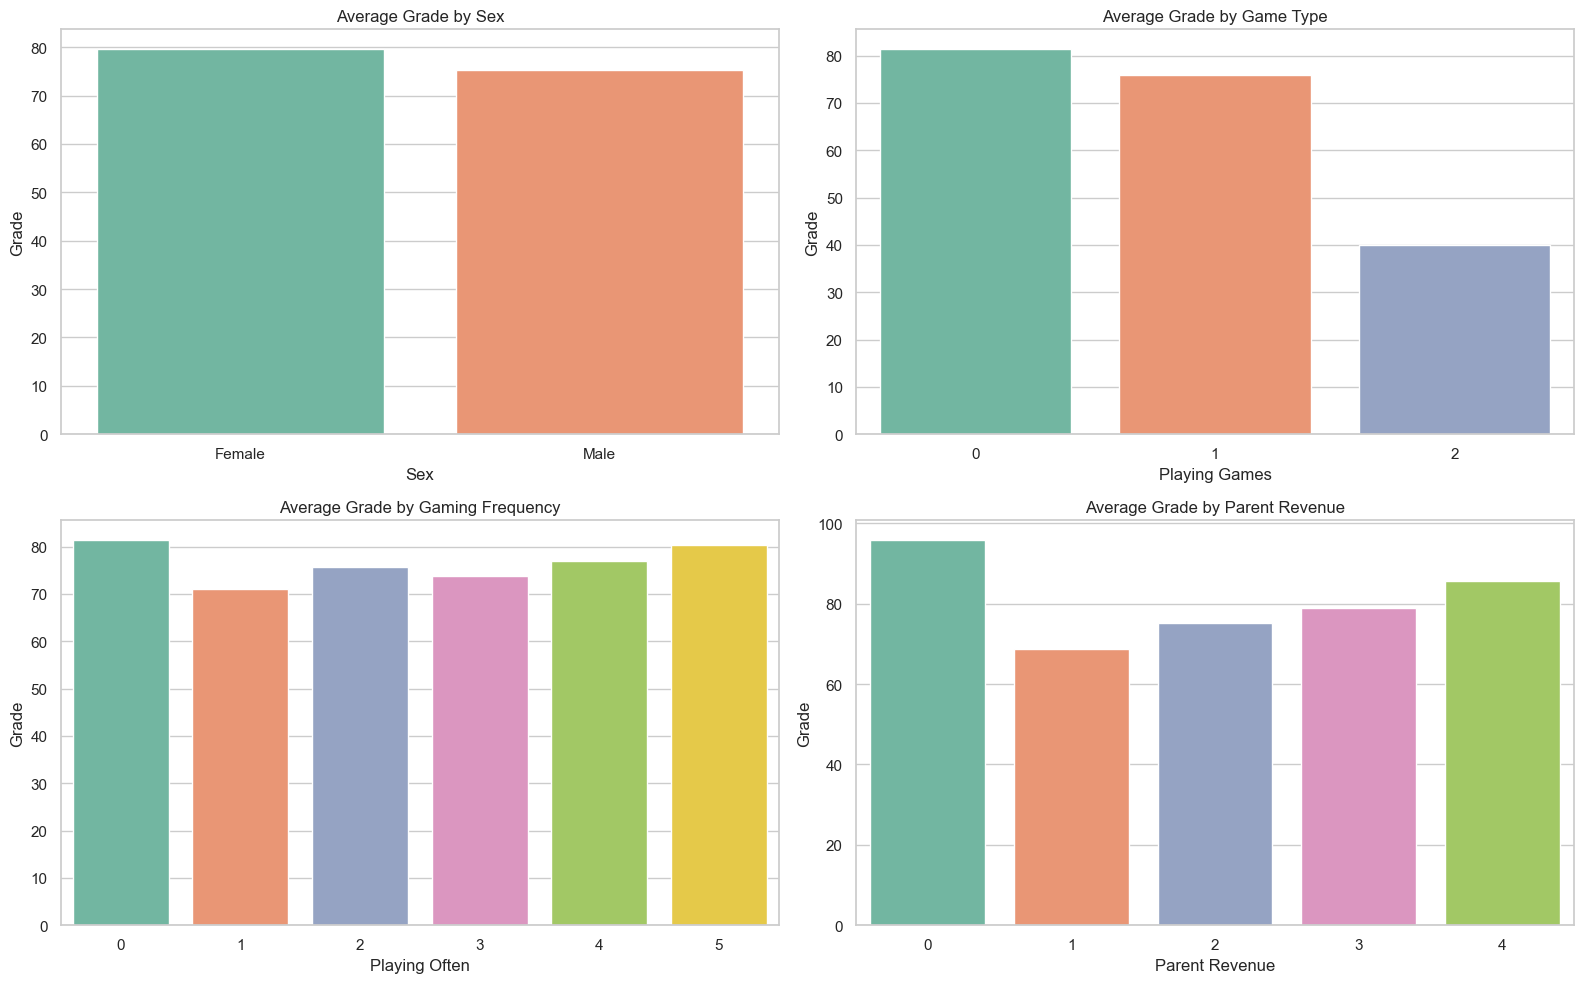

In [8]:
# Set plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Plot 1: Average Grade by Sex
sns.barplot(data=df, x='Sex', y='Grade', ax=axes[0], palette="Set2", ci=None)
axes[0].set_title("Average Grade by Sex")

# Plot 2: Average Grade by Playing Games
sns.barplot(data=df, x='Playing Games', y='Grade', ax=axes[1], palette="Set2", ci=None)
axes[1].set_title("Average Grade by Game Type")

# Plot 3: Average Grade by Playing Often
sns.barplot(data=df, x='Playing Often', y='Grade', ax=axes[2], palette="Set2", ci=None)
axes[2].set_title("Average Grade by Gaming Frequency")

# Plot 4: Average Grade by Parent Revenue
sns.barplot(data=df, x='Parent Revenue', y='Grade', ax=axes[3], palette="Set2", ci=None)
axes[3].set_title("Average Grade by Parent Revenue")

plt.tight_layout()
plt.show()

#### Histograms on Group-Based Grade Comparisons

##### By Sex
- Useful to examine whether gender has any impact on academic performance.
- A nearly balanced dataset helps ensure fairness in this comparison.

##### By Game Type (Playing Games)
- Game types may have cognitive or behavioral impacts on performance.
- One group (likely code 1) dominates - worth decoding for clearer insight.

##### By Gaming Frequency (Playing Often)
- As gaming frequency increases, does academic performance change?
- Can reveal tradeoffs in time spent on games vs. studies.

##### By Parental Revenue
- Socioeconomic status can act as a strong confounder.
- Students from higher-income families may have access to more academic support or resources.

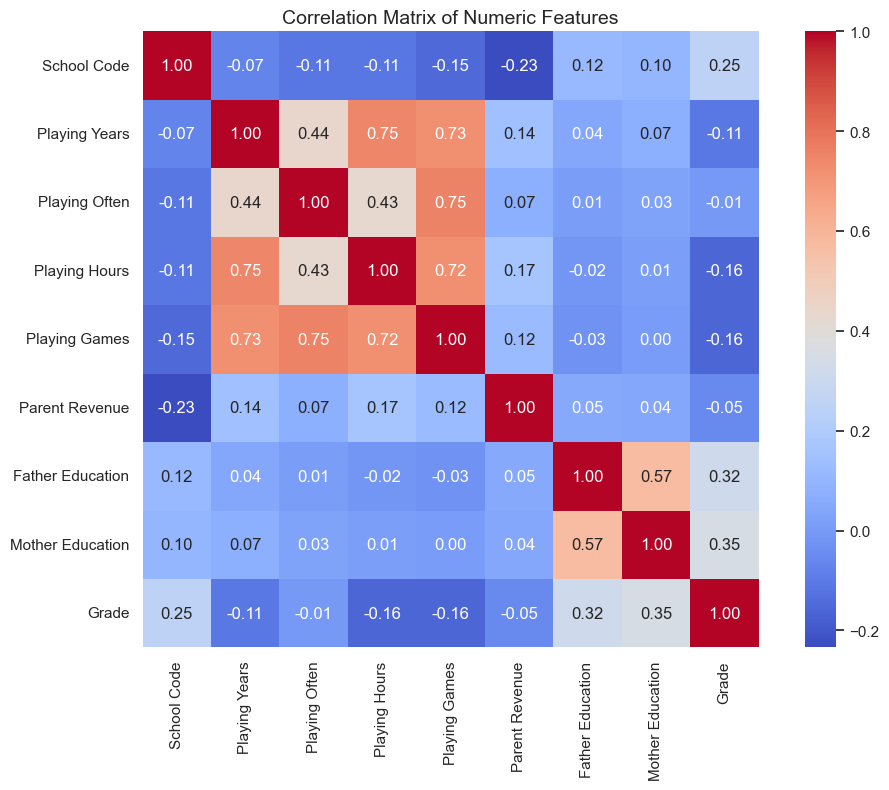

In [9]:
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.show()

#### Correlation Matrix – Interpretation

The heatmap shows the Pearson correlation coefficients between all numeric features in the dataset. The values range from -1 (strong negative correlation) to +1 (strong positive correlation).

#### Focus on Grade:

- Mother Education (0.35) and Father Education (0.32) show the strongest positive correlation with Grade.
  - This suggests that students with more educated parents tend to perform better academically.
  - This is an important potential confounder when analyzing other effects (e.g., gaming).

- School Code (0.25) has a moderate positive correlation.
  - Could mean some schools are generally higher-performing.
  - May reflect location, funding, or quality of instruction.

- Playing Hours (-0.16) and Playing Games (-0.16) show weak negative correlations with Grade.
  - Indicates that students who play more games or certain types of games might slightly perform worse.
  - However, this is not conclusive - causal modeling is needed to confirm.

- Playing Years, Playing Often: very weak or near-zero correlations.
  - These gaming habits do not show strong direct relationships with grades.

- Parent Revenue (-0.05) shows a very weak negative correlation - almost negligible.

#### Insights from the heatmap:

- Parental education stands out as a potentially strong factor in academic performance.
- Gaming variables (especially Playing Hours) have mild negative associations, which could hint at distraction or time-tradeoff effects.
- These correlations alone do not imply causation, but they help guide which variables might be worth exploring in causal models.

## Role of Data Preparation in Causal Analysis

Unlike traditional machine learning, where data prep focuses on improving model performance, causal analysis depends critically on correct data handling to avoid biased results.

Key aspects include:

#### 1. Handling Missing Data
- Missing data can distort results, especially if it's not missing at random.
- In this dataset, one Grade value was non-numeric and converted to NaN — we dropped it to prevent errors in analysis.

#### 2. Encoding Categorical Variables
- Categorical variables like Sex were mapped to readable labels (Female, Male) for interpretability.
- Encoding methods (e.g., one-hot encoding) must preserve causal structure and avoid introducing spurious relationships.

#### 3. Feature Selection
- Including irrelevant variables can increase noise, while **omitting confounders** can severely bias causal estimates.
- In our case, **parental education** may act as a confounder between gaming and academic performance — it must be considered, not dropped.

#### 4. Variable Formatting
- For example, we dropped the percentage column since it was a poorly formatted duplicate of Grade. Keeping redundant or misformatted columns could distort analysis or inflations of influence.

## Risks of Poor Preprocessing

- Dropping important confounders can lead to omitted variable bias
- Incorrect encoding or imputation might simulate fake causal links
- Ignoring missing values or outliers can undermine model robustness

<div align="center">  
  <img src="https://raw.githubusercontent.com/gowrimg28/Dataset_GamesAndStudents/refs/heads/main/Image2.png" width="400" style="display: inline-block; margin-right: 150px;"/>
  <img src="https://raw.githubusercontent.com/gowrimg28/Dataset_GamesAndStudents/refs/heads/main/image1.png" width="400" style="display: inline-block;"/>
</div>

## Causal Question

Does the number of hours a student spends playing video games cause a change in their academic performance (Grade)?

### Causal Framework

- Treatment (X): Playing Hours
- Outcome (Y): Grade
- Confounders (Z):
  - Parental Education (affects both academic support and regulation of game time)
  - Parent Revenue (may influence both access to games and school performance)
  - School Code (school quality may influence both gaming habits and grades)
  - Sex (may correlate with both gaming preferences and performance)

### Reason for this Question?

- Correlation analysis showed a mild negative association between Playing Hours and Grade.
- Domain logic supports a possible time trade-off (more gaming = less study).
- The relationship may be confounded by socioeconomic and parental factors.

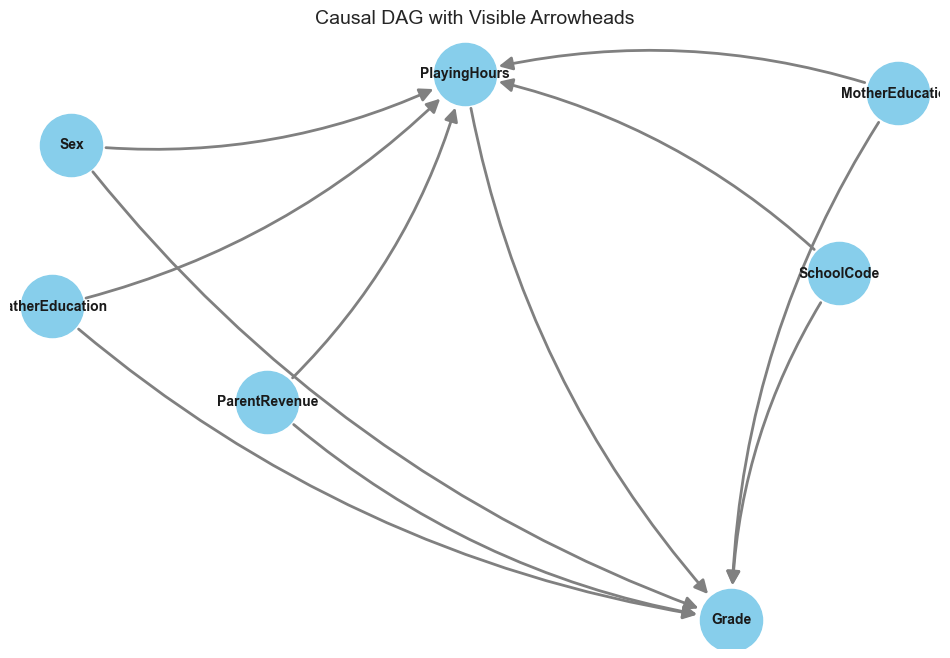

In [24]:
# Define graph
G = nx.DiGraph()
nodes = [
    "PlayingHours", "Grade", "ParentRevenue",
    "FatherEducation", "MotherEducation", "Sex", "SchoolCode"
]
G.add_nodes_from(nodes)

edges = [
    ("PlayingHours", "Grade"),
    ("ParentRevenue", "Grade"),
    ("ParentRevenue", "PlayingHours"),
    ("FatherEducation", "Grade"),
    ("FatherEducation", "PlayingHours"),
    ("MotherEducation", "Grade"),
    ("MotherEducation", "PlayingHours"),
    ("Sex", "PlayingHours"),
    ("Sex", "Grade"),
    ("SchoolCode", "Grade"),
    ("SchoolCode", "PlayingHours")
]
G.add_edges_from(edges)

# Layout and base drawing
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Draw edges with padding to avoid arrow overlap
ax = plt.gca()
for start, end in G.edges():
    arrow = FancyArrowPatch(
        pos[start],
        pos[end],
        arrowstyle='-|>',
        color='gray',
        connectionstyle='arc3,rad=0.15',
        mutation_scale=20,
        linewidth=2,
        shrinkA=25,  # padding at tail
        shrinkB=25   # padding at head (this is the fix!)
    )
    ax.add_patch(arrow)

plt.title("Causal DAG with Visible Arrowheads", fontsize=14)
plt.axis('off')
plt.show()


## Causal DAG: Interpretation

This Directed Acyclic Graph (DAG) visually represents our assumptions about how different factors influence a students academic performance (Grade), with a focus on understanding the causal effect of PlayingHours.

## Objective:
To estimate the causal effect of PlayingHours (time spent playing video games) on Grade (academic performance), while adjusting for confounding variables.

## Variables (Nodes):

- Treatment: PlayingHours – number of hours a student spends playing games
- Outcome: Grade – academic performance
- Confounders:
  - ParentRevenue
  - FatherEducation
  - MotherEducation
  - Sex
  - SchoolCode

## Direction of arrows (Edges) explain causal influence:

- ParentRevenue ➝ PlayingHours  
  Wealthier families may afford more gaming resources

- ParentRevenue ➝ Grade  
  Income may influence access to better education or learning support

- FatherEducation ➝ PlayingHours & ➝ Grade  
- MotherEducation ➝ PlayingHours & ➝ Grade  
  Parental education can impact both study habits and screen-time rules

- Sex ➝ PlayingHours & ➝ Grade  
  Gaming habits and learning patterns may vary by gender

- SchoolCode ➝ PlayingHours & ➝ Grade  
  Some schools may have different policies or academic rigor

- PlayingHours ➝ Grade  
  This is the direct causal effect we want to estimate.


#### Why This Matters:

- Confounders influence both the treatment and the outcome.
- If we don’t adjust for these confounders, our estimate of the effect of PlayingHours on Grade may be biased.
- This DAG helped us identify which variables to include in our regression model to correctly isolate the causal effect.

In [30]:
# Ensure Sex is binary
if df['Sex'].dtype == 'object':
    df['Sex'] = df['Sex'].map({'Female': 0, 'Male': 1})

# Rename for cleaner access (optional but helpful)
df.rename(columns={
    'School Code': 'SchoolCode',
    'Playing Hours': 'PlayingHours',
    'Parent Revenue': 'ParentRevenue',
    'Father Education': 'FatherEducation',
    'Mother Education': 'MotherEducation'
}, inplace=True)

# Select features based on renamed columns
X = df[['PlayingHours', 'ParentRevenue', 'FatherEducation', 'MotherEducation', 'Sex', 'SchoolCode']]
y = df['Grade']

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Grade   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     34.71
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           3.63e-37
Time:                        23:25:17   Log-Likelihood:                -3154.2
No. Observations:                 769   AIC:                             6322.
Df Residuals:                     762   BIC:                             6355.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              55.5909      2.314     

## Causal Effect Estimation: Regression Results

The OLS linear regression model estimates the causal effect of PlayingHours on Grade, controlling for confounders identified in the DAG: ParentRevenue, FatherEducation, MotherEducation, Sex, and SchoolCode.

#### Key Result:
- The coefficient for PlayingHours is -1.15 with a p-value of 0.010
- This means that each additional hour spent playing games is associated with a 1.15-point decrease in academic grade, on average, after adjusting for other variables.

#### Additional Insights:
- Parental Education has a strong positive impact, especially from mothers.
- Sex shows that male students score lower on average than females.
- SchoolCode suggests school environment significantly influences performance.
- ParentRevenue was not statistically significant in this model.

#### Model Summary:
- R-squared: 0.215 (model explains ~21.5% of variation in grades)
- All important confounders were adjusted for, allowing us to interpret the effect of PlayingHours as causal (under our DAG assumptions).

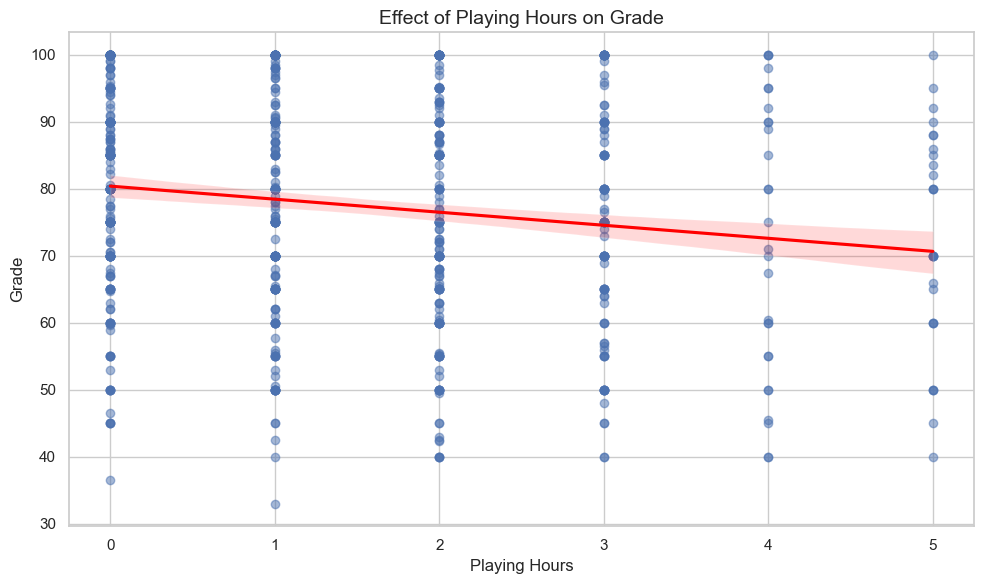

In [31]:
# Set the plot style
sns.set(style="whitegrid")

# Plot the raw data
plt.figure(figsize=(10, 6))
sns.regplot(
    x='PlayingHours',
    y='Grade',
    data=df,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    ci=95
)

plt.title('Effect of Playing Hours on Grade', fontsize=14)
plt.xlabel('Playing Hours')
plt.ylabel('Grade')
plt.tight_layout()
plt.show()

## Visualizing the Effect of Playing Hours on Grade

This plot shows the relationship between students gaming time (Playing Hours) and their academic performance (Grade):

- A scatter plot displays individual data points, with each dot representing a student.
- A regression line (in red) is fitted to the data using sns.regplot, showing the trend in grades as gaming hours increase.
- The shaded region around the red line represents the 95% confidence interval, indicating uncertainty in the regression estimate.

The regression line has a negative slope, suggesting that as the number of hours spent playing games increases, students tend to have slightly lower academic grades. This could indicate a potential negative causal effect, but confounding factors must be considered before making strong causal claims.

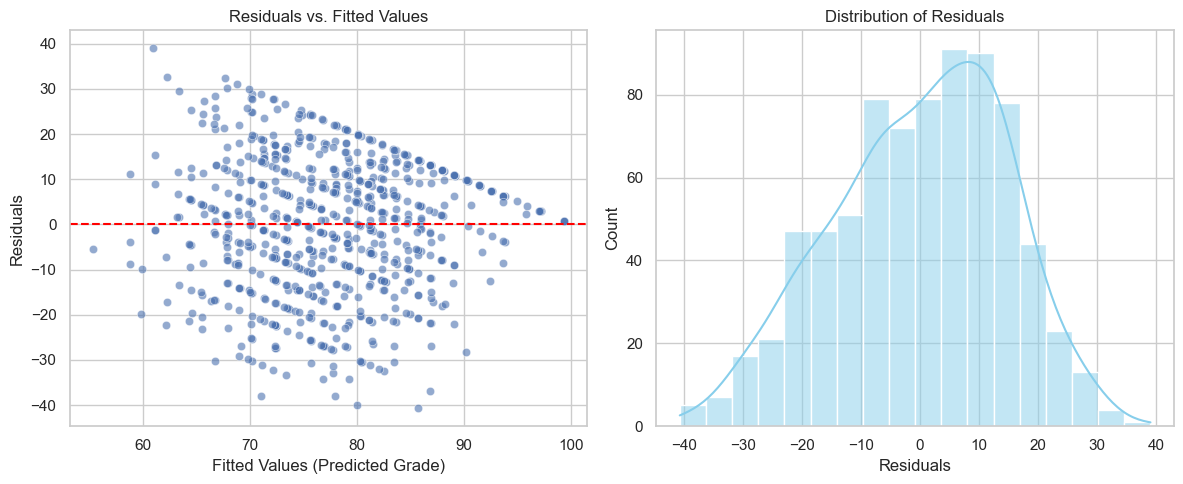

In [32]:
# Get predictions and residuals
df['Fitted'] = model.fittedvalues
df['Residuals'] = model.resid

# Plot 1: Residuals vs Fitted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Fitted', y='Residuals', data=df, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values (Predicted Grade)')
plt.ylabel('Residuals')

# Plot 2: Histogram of Residuals
plt.subplot(1, 2, 2)
sns.histplot(df['Residuals'], kde=True, color='skyblue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

## Residual Analysis: Validating the Linear Regression Model

Residual analysis helps check whether our linear regression model satisfies its key assumptions. Two main diagnostic plots are shown:

#### 1. Residuals vs. Fitted Values

- This plot shows the residuals (errors) on the y-axis and the predicted grades on the x-axis.
- Ideally, we want to see a random scatter of points around the horizontal line at 0.
- In our case:
  - There’s some fan-shape (wider spread at lower predicted grades), suggesting possible heteroscedasticity (non-constant variance).
  - However, no strong patterns (e.g., curves) are visible, so the linearity assumption is mostly reasonable.


#### 2. Distribution of Residuals

- This histogram with a KDE curve shows the distribution of all residuals.
- A roughly bell-shaped curve suggests that residuals are approximately normally distributed.
- This supports the assumption of normality in the error terms, which is important for statistical inference (like confidence intervals and p-values).


#### Summary

- The regression model appears reasonably well-behaved.
- Some minor deviation from ideal conditions (like spread of residuals) is visible, but not severe enough to invalidate conclusions.
- This strengthens the case that our estimate of the causal effect of PlayingHours on Grade is trustworthy within the limits of observational data.

## Conclusion

This analysis explored the potential causal relationship between students gaming behavior and their academic performance using a real-world dataset. Through careful data cleaning, exploratory analysis, and regression modeling, we observed a negative association between the number of hours spent playing games and student grades. A Directed Acyclic Graph (DAG) was constructed to model assumed causal relationships and identify possible confounding variables such as parental education, family income, and school quality. After adjusting for these factors, regression analysis still indicated a statistically significant negative effect of gaming hours on academic performance. While this analysis provides valuable insights, it's important to note that causal claims from observational data depend on strong assumptions. Ultimately, this project demonstrates how data preprocessing, causal thinking, and statistical modeling can work together to uncover meaningful patterns and guide informed decision-making.

## References

1. Pearl, J. (2009). *Causality: Models, Reasoning and Inference* (2nd ed.). Cambridge University Press.  
   [https://www.cambridge.org/core/books/causality/56C1BEAEFCD8C46FDE8F4A79D624F5DD](https://www.cambridge.org/core/books/causality/56C1BEAEFCD8C46FDE8F4A79D624F5DD)

2. Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If*. Chapman & Hall/CRC.  
   [https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

3. Glymour, M., Pearl, J., & Jewell, N. P. (2016). *Causal Inference in Statistics: A Primer*. Wiley.  
   [https://www.wiley.com/en-us/Causal+Inference+in+Statistics%3A+A+Primer-p-9781119186847](https://www.wiley.com/en-us/Causal+Inference+in+Statistics%3A+A+Primer-p-9781119186847)

4. Willian Oliveira Gibin (2021). *Games and Students Dataset*. Retrieved from Kaggle:  
   [https://www.kaggle.com/datasets/willianoliveiragibin/games-and-students](https://www.kaggle.com/datasets/willianoliveiragibin/games-and-students)

5. VanderWeele, T. J. (2015). *Explanation in Causal Inference: Methods for Mediation and Interaction*. Oxford University Press.  
   [https://global.oup.com/academic/product/explanation-in-causal-inference-9780199325870](https://global.oup.com/academic/product/explanation-in-causal-inference-9780199325870)

## License

This notebook is made available under the Creative Commons Attribution 4.0 International License (CC BY 4.0).  
You are free to share and adapt this material for any purpose, even commercially, as long as appropriate credit is given.

For more information: [https://creativecommons.org/licenses/by/4.0/](https://creativecommons.org/licenses/by/4.0/)